In [ ]:
#%%

import os
os.makedirs('./census_income/plots', exist_ok=True)
os.makedirs('./census_income/models', exist_ok=True)

from ucimlrepo import fetch_ucirepo 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from collections import Counter
import time

import pickle
from joblib import dump

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [ ]:
#%%

# fetch dataset 
adult = fetch_ucirepo(id=2) 
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [ ]:
# %%

# Let's join our dataframe to a better analysis
df = pd.concat([adult.data.features,adult.data.targets], axis=1)

In [ ]:
# %%

# First sense of dataset
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
#%%

df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
# %%

print (f"{df.shape=}")

df.shape=(48842, 15)


In [ ]:
# %%

# Missing values Analysis
df = df.replace('?', np.nan)

print(f"Any NaN Value? {df.isna().any().any()}")

Any NaN Value? True


workclass         2799
occupation        2809
native-country     857
dtype: int64
workclass         5.730724
occupation        5.751198
native-country    1.754637
dtype: float64


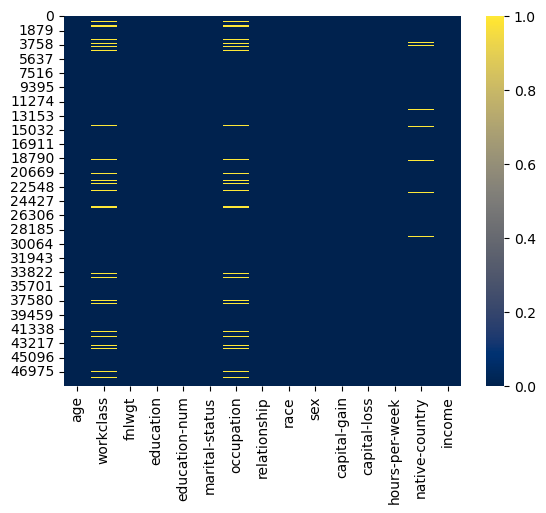

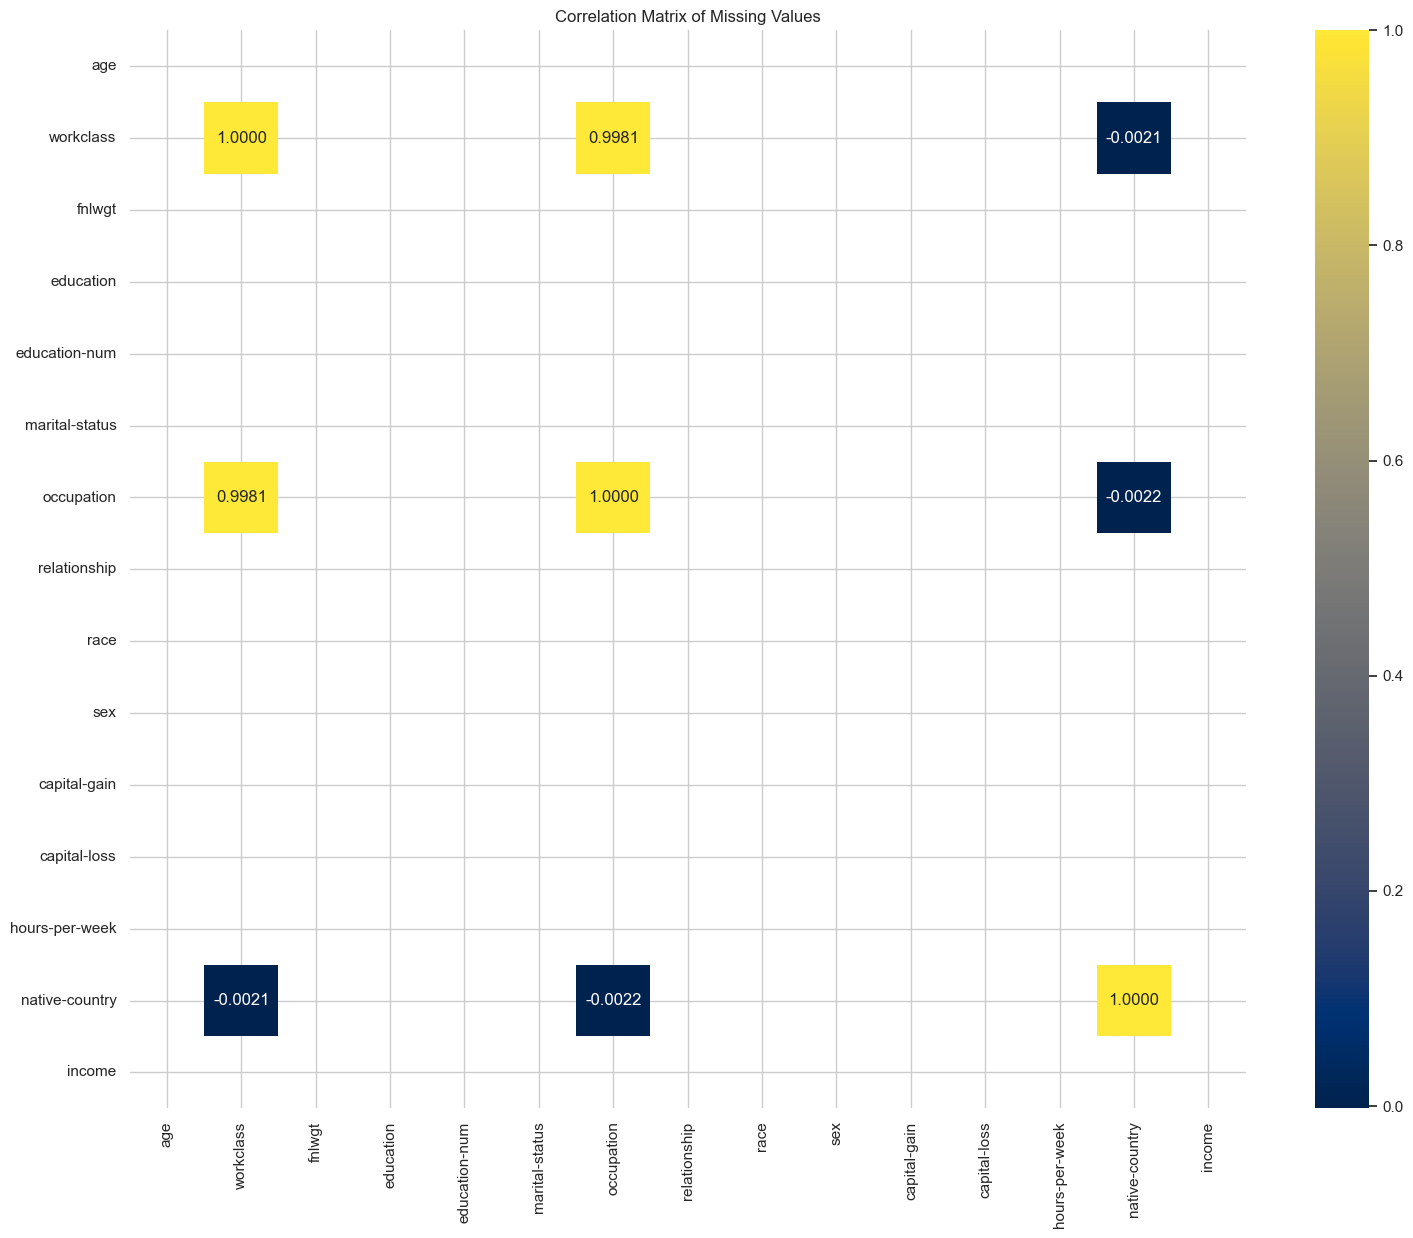

Empty DataFrame
Columns: [age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, income]
Index: []
       age     workclass  fnlwgt     education  education-num  \
5361    18  Never-worked  206359          10th              6   
10845   23  Never-worked  188535       7th-8th              4   
14772   17  Never-worked  237272          10th              6   
20337   18  Never-worked  157131          11th              7   
23232   20  Never-worked  462294  Some-college             10   
32304   30  Never-worked  176673       HS-grad              9   
32314   18  Never-worked  153663  Some-college             10   
41346   17  Never-worked  131593          11th              7   
44168   20  Never-worked  273905       HS-grad              9   
46459   18  Never-worked  162908          11th              7   

              marital-status occupation    relationship   race     sex  \
536

In [ ]:
#%%

# 1. Detecting columns with missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# 2. Calculating the percentage of missing values
missing_percentage = df.isnull().mean() * 100
print(missing_percentage[missing_percentage > 0])

# 3. Analizing pattern of missing values
#   a. Heatmap
sns.heatmap(df.isnull(), cbar=True, cmap="cividis")
if not os.path.exists('./census_income/plots/heatmap_missing_values.png'):
    plt.savefig('./census_income/plots/heatmap_missing_values.png')
plt.show()

#   b. Correlation between missing values
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 14))
sns.heatmap(df.isnull().corr(), annot=True, cmap="cividis", fmt=".4f")
plt.title("Correlation Matrix of Missing Values")
if not os.path.exists('./census_income/plots/correlation_missing_values.png'):
    plt.savefig('./census_income/plots/correlation_missing_values.png')
plt.show()

#   c. Missing Pattern Analysis
missing_workclass_only = df[df['workclass'].isnull() & df['occupation'].notnull()]
missing_occupation_only = df[df['occupation'].isnull() & df['workclass'].notnull()]

print(missing_workclass_only)
print(missing_occupation_only)

occupation        Adm-clerical  Armed-Forces  Craft-repair  Exec-managerial  \
workclass                                                                     
Federal-gov                487            15            93              268   
Local-gov                  421             0           211              331   
Private                   4208             0          4748             3995   
Self-emp-inc                47             0           167              617   
Self-emp-not-inc            70             0           798              587   
State-gov                  375             0            94              287   
Without-pay                  3             0             1                1   

occupation        Farming-fishing  Handlers-cleaners  Machine-op-inspct  \
workclass                                                                 
Federal-gov                     9                 36                 19   
Local-gov                      43                 65           

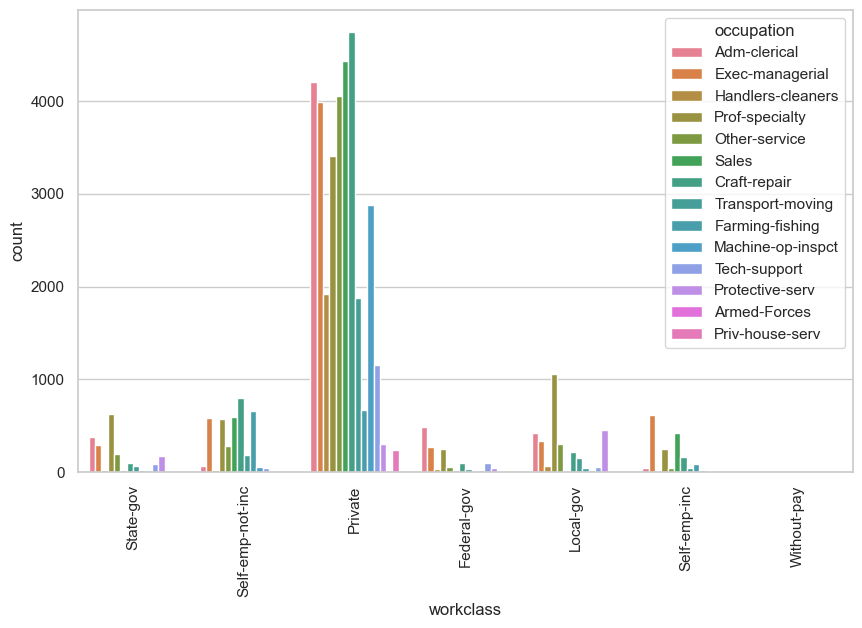

occupation        Adm-clerical  Armed-Forces  Craft-repair  Exec-managerial  \
workclass                                                                     
Federal-gov           0.086794           1.0      0.015216         0.044035   
Local-gov             0.075031           0.0      0.034522         0.054387   
Private               0.749955           0.0      0.776832         0.656425   
Self-emp-inc          0.008376           0.0      0.027323         0.101380   
Self-emp-not-inc      0.012475           0.0      0.130563         0.096451   
State-gov             0.066833           0.0      0.015380         0.047157   
Without-pay           0.000535           0.0      0.000164         0.000164   

occupation        Farming-fishing  Handlers-cleaners  Machine-op-inspct  \
workclass                                                                 
Federal-gov              0.006040           0.017375           0.006287   
Local-gov                0.028859           0.031371           

In [ ]:
# %%

# 4. Logic relation between correlated missing-values features
#   a. Cross-Analysis
subset = df.dropna(subset=['workclass', 'occupation'])
contingency_table = pd.crosstab(subset['workclass'], subset['occupation'])
print (contingency_table)

#   b. Countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=subset, x='workclass', hue='occupation')
plt.xticks(rotation=90)
if not os.path.exists('./census_income/plots/countplot_missing_values.png'):
    plt.savefig('./census_income/plots/countplot_missing_values.png')
plt.show()

#   c. Conditional probabilities
workclass_given_occupation = contingency_table.div(contingency_table.sum(axis=0), axis=1)
print(workclass_given_occupation)
print ("-"*60)
occupation_given_workclass = contingency_table.div(contingency_table.sum(axis=1), axis=0)
print(occupation_given_workclass)

In [ ]:
# %%

# 5. Missing values imputation

# Imputing for 'occupation'
# Choosing from conditional probability after a certain threshold
threshold = 0.05
mode_workclass = df['workclass'].mode()[0]

for i, row in df.iterrows():
    if pd.isna(row['occupation']):
        workclass_value = row['workclass']
        
        if pd.isna(workclass_value):
            workclass_value = mode_workclass
            
        if workclass_value == "Never-worked":
            continue
        
        if workclass_value in occupation_given_workclass.index:
            occupation_probs = occupation_given_workclass.loc[workclass_value] #Loc for a specific row
            
            valid_occupations = occupation_probs[occupation_probs > threshold].index
            
            if len(valid_occupations) > 0:
                df.at[i, 'occupation'] = random.choice(valid_occupations)
            else: 
                raise ValueError(f"There is no value greater than the threshold.")
        else:
            raise ValueError(f"The value of 'workclass' is not valid: {workclass_value}")

In [ ]:
# %%

# Now we check if there is any NaN for occupation (excluding Never-worked)
print(df[df['workclass'] != 'Never-worked']['occupation'].isna().any())

False


In [ ]:
# %%

# Imputing for 'workclass'
# Choosing from conditional probability after a certain threshold
for i, row in df.iterrows():
    if pd.isna(row['workclass']):
        occupation_value = row['occupation']

        if occupation_value in workclass_given_occupation.columns:
            workclass_probs = workclass_given_occupation[occupation_value]  #No need for loc = Looking for columns      
            
            valid_workclasses = workclass_probs[workclass_probs > threshold].index
            
            if len(valid_workclasses) > 0:
                df.at[i, 'workclass'] = random.choice(valid_workclasses)
            else: 
                raise ValueError(f"There is no value greater than the threshold.")
        else:
            raise ValueError(f"The value of 'occupation' is not  valid: {workclass_value}")

In [ ]:
# %%

# Now we check if there is any NaN for workclass (excluding Never-worked)
print(df[df['workclass'] != 'Never-worked']['workclass'].isna().any())

False


In [ ]:
# %%

# Finally, imputing 'native-country'.
# Random Imputing - to mantain variability of our dataframe.
categories = df['native-country'].dropna().unique()

missing_mask = df['native-country'].isnull()

df.loc[missing_mask, 'native-country'] = np.random.choice(categories, size=missing_mask.sum())

In [ ]:
#%%

# Final check!
print(df[df['workclass'] != 'Never-worked'].isna().any())

age               False
workclass         False
fnlwgt            False
education         False
education-num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool


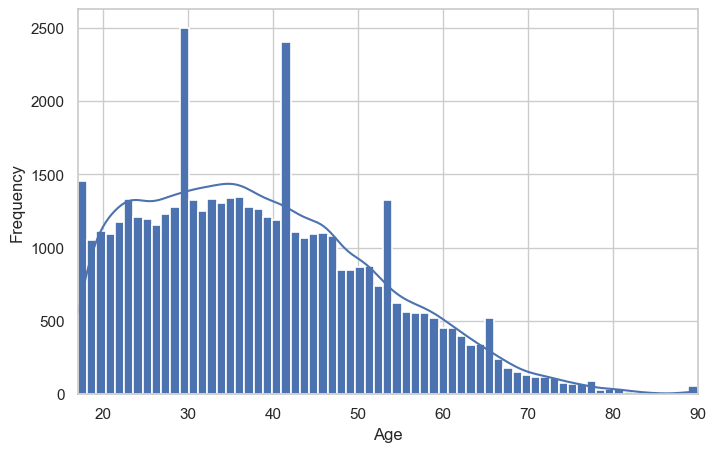

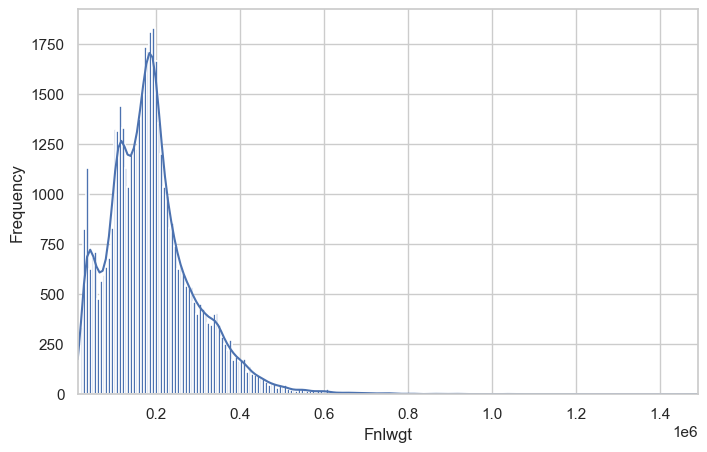

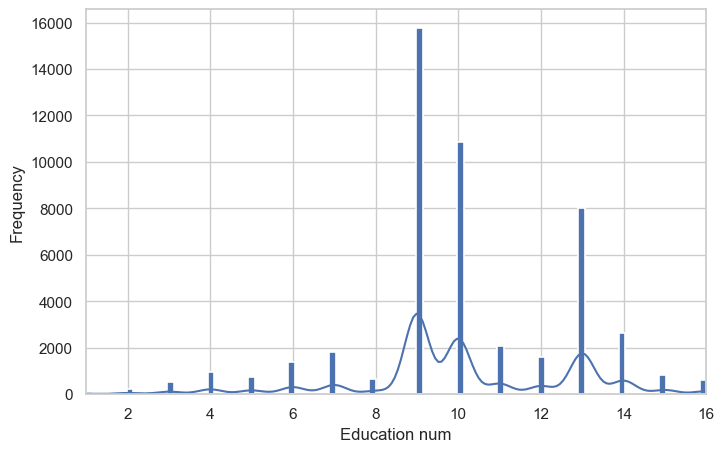

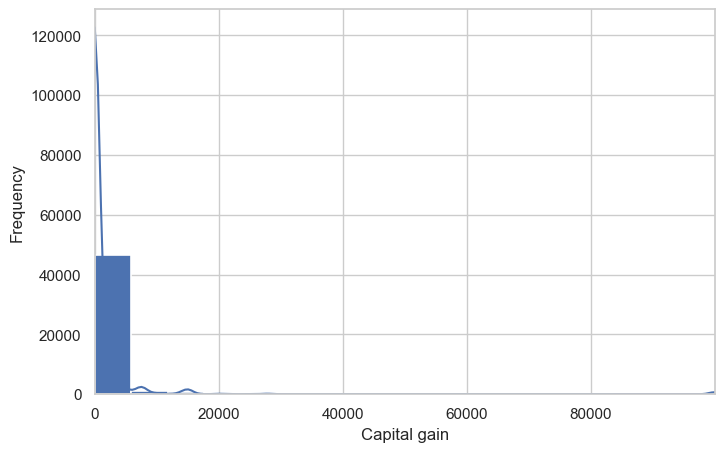

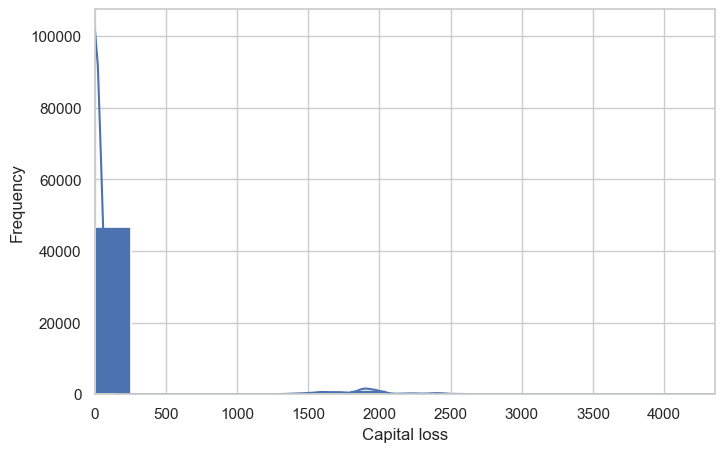

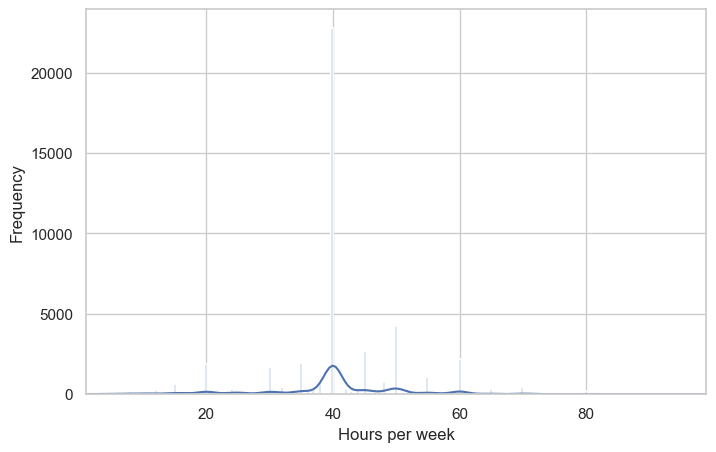

In [ ]:
#%%

# 6. Inspecting continous data distribution
X = df.drop('income', axis=1)

#¡Duplicated column!
X.drop('education', axis=1)

numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
num_variance = {}
for feature in (numerical_features):
    plt.figure(figsize=(8, 5)) 
    sns.histplot(x=X[feature], color='b', kde=True, linewidth=1.2, alpha=1)
    
    plt.xlabel(feature.replace('-', ' ').capitalize(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xlim([min(X[feature].values), max(X[feature].values)])
    
    filename = "dist_" + feature + ".png"
    file_path = os.path.join('./census_income/plots', filename)
    if not os.path.exists(file_path):
        plt.savefig(file_path)
    plt.show()

    num_variance[feature] = X[feature].var()

In [ ]:
#%%

# Print variance
for key, value in zip(num_variance.keys(), num_variance.values()):
    print (f"{key}={value:.2f}")

age=187.98
fnlwgt=11152210185.57
education-num=6.61
capital-gain=55532588.04
capital-loss=162412.67
hours-per-week=153.55


In [ ]:
# %%

# 7. Inspecting categories data distribution

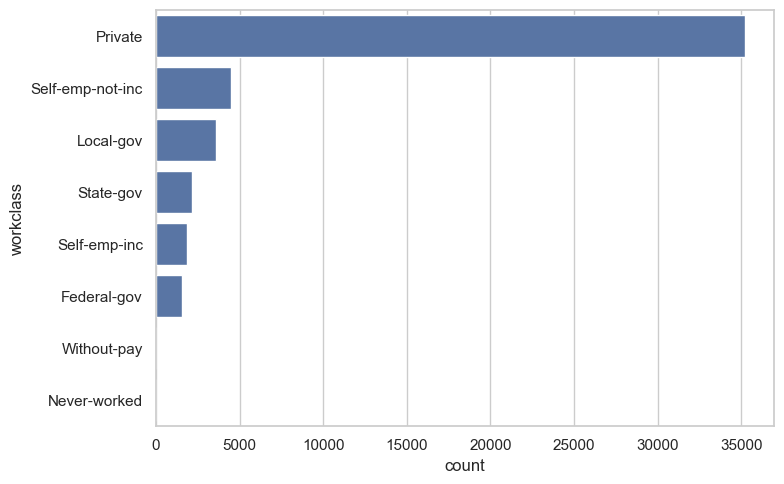

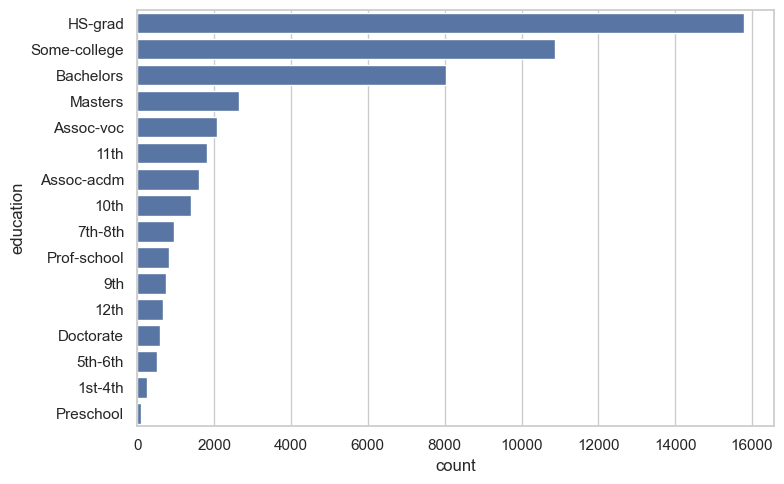

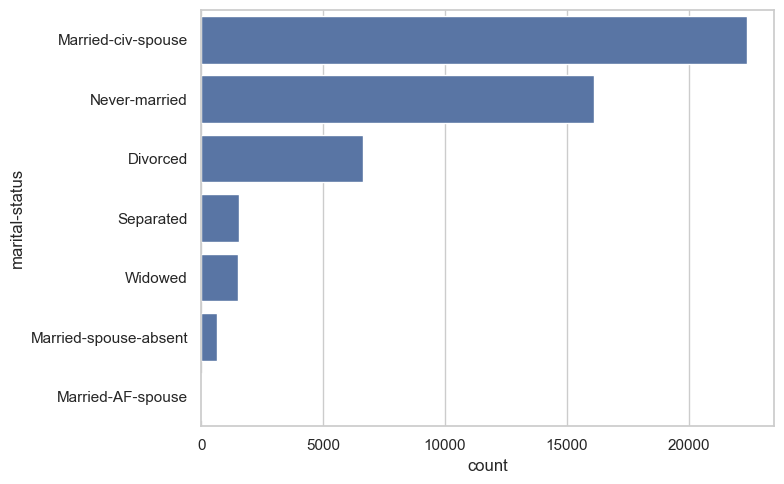

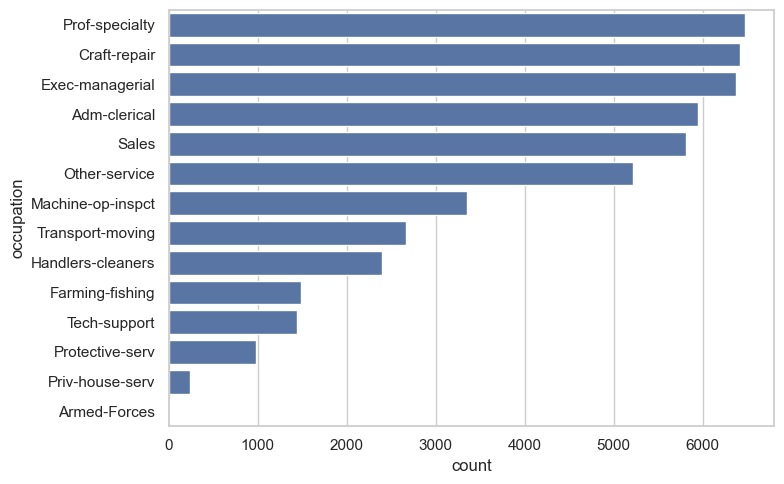

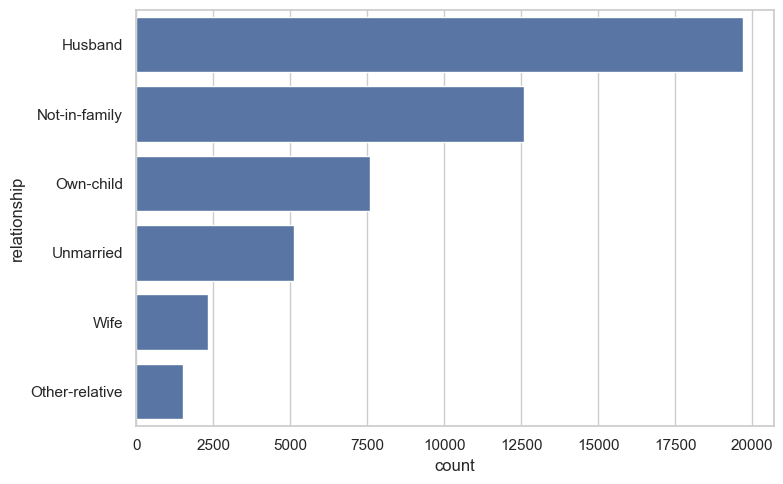

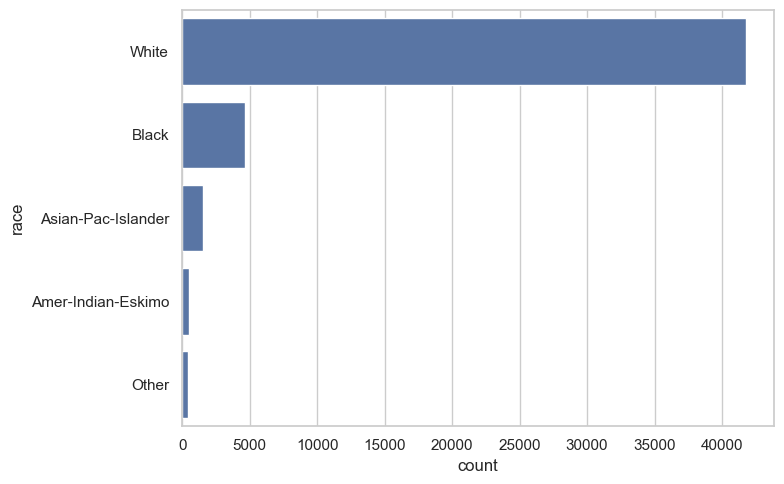

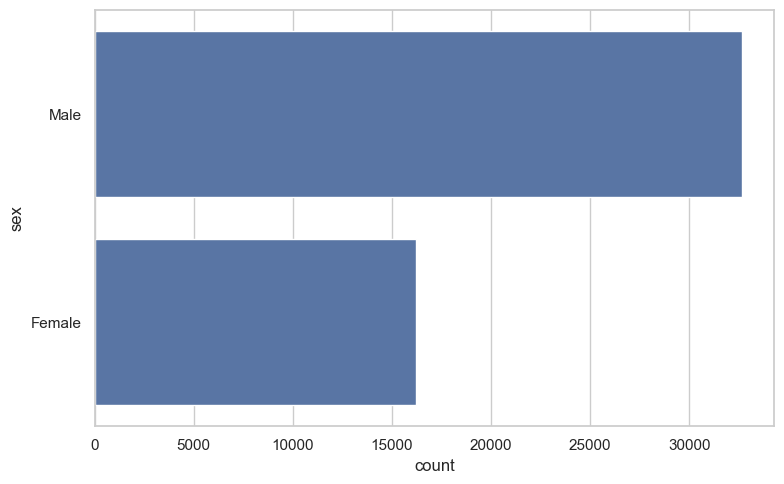

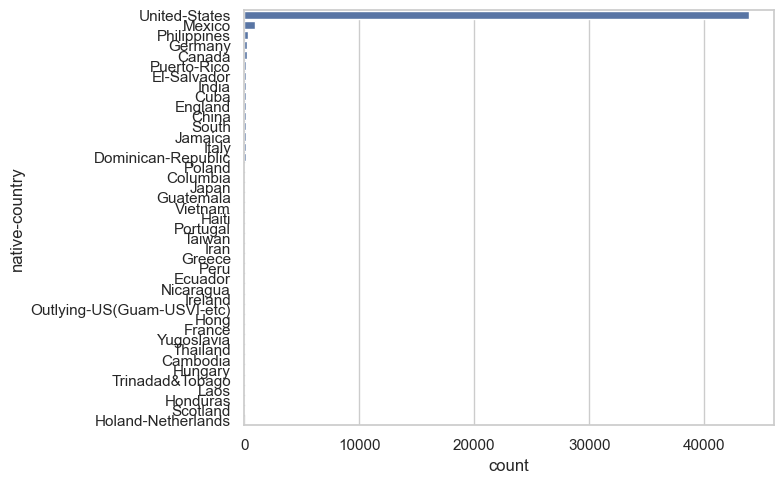

In [ ]:
# %%

categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']

for feature in (categorical_features):
    plt.figure(figsize=(8, 5))
    sns.countplot(y=feature, data=df, order=df[feature].value_counts().index)
    plt.tight_layout()

    filename = "cplot_" + feature + ".png"
    file_path = os.path.join('./census_income/plots', filename)
    if not os.path.exists(file_path):
        plt.savefig(file_path)
    plt.show()

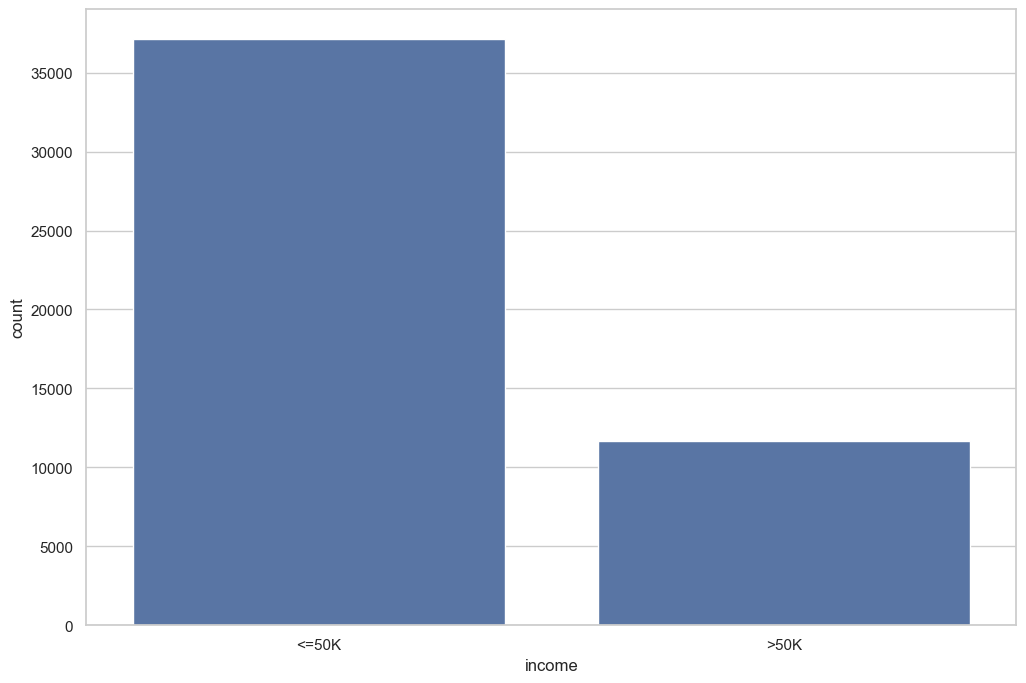

In [ ]:
#%%

# 8. Analyzing target distribution
# ¡First curate the bad target names! 
df['income'] = df['income'].str.replace('.','', regex=False)
y = df['income'] 

#Need to do this for test also, if we have production. Need this mapping.
y = y.map({'<=50K': 0, '>50K': 1})

plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='income')
if not os.path.exists('./census_income/plots/income_unbalanced_distr.png'):
    plt.savefig('./census_income/plots/income_unbalanced_distr.png')
plt.show()

In [ ]:
#%%

print (len(df[df['income'] == '>50K'])/(len(df['income'])))

0.23928176569346055


In [ ]:
# %%

# 9. Normalizating numerical features
X[numerical_features] = RobustScaler().fit_transform(X[numerical_features])

In [ ]:
# %%

# 10. Codifying categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # drop='first' para evitar la multicolinealidad
encoded_categorical = encoder.fit_transform(X[categorical_features])

encoded_X = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features))

X = X.drop(columns=categorical_features).reset_index(drop=True)
encoded_X = encoded_X.reset_index(drop=True)
X = pd.concat([X, encoded_X], axis=1)
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.10,-0.837932,1.000000,2174.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.65,-0.789677,1.000000,0.0,0.0,-5.4,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.05,0.312274,-0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.80,0.471112,-1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.45,1.334520,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#%%

# 11. Splitting original dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37, stratify=y)

In [ ]:
# %%

# 12. Under-sampling and over-sampling pipeline
data_pipeline = Pipeline(steps=[
    ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=37)),  
    ('over', SMOTE(random_state=37)),            
])
X_resampled, y_resampled = data_pipeline.fit_resample(X_train, y_train)

<ipython-input-27-0e0ffa5b3b00>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  count_plot.set_xticklabels(['<=50K', '>50K'])


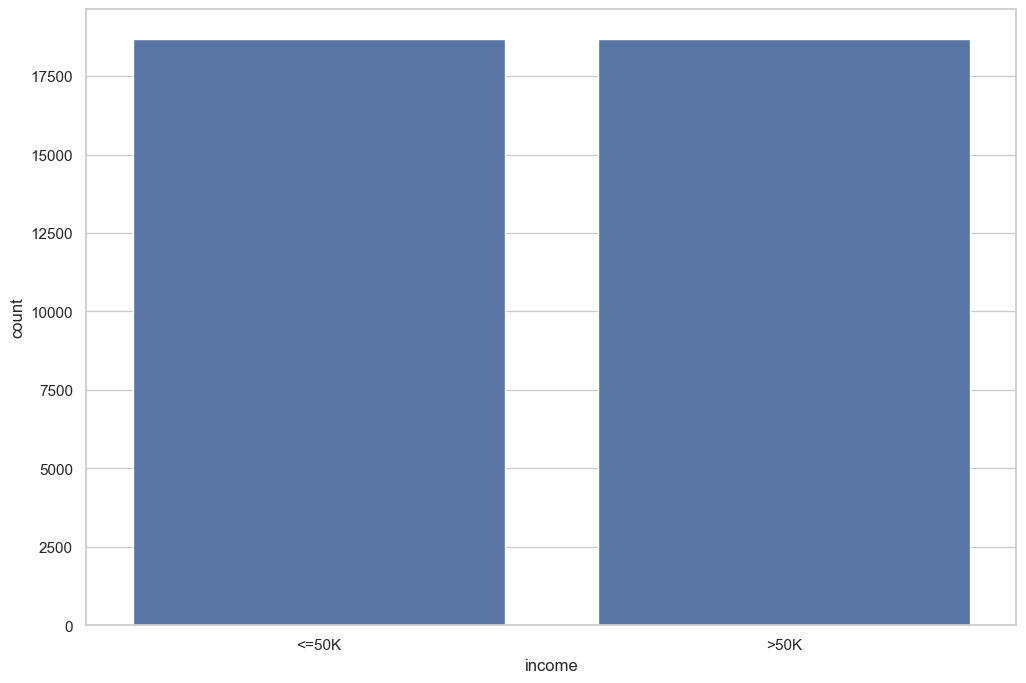

In [ ]:
# %%

# 13. New distribution is...
resampled_data_train = pd.DataFrame(X_resampled, columns=X_train.columns) 
resampled_data_train['target'] = y_resampled

plt.figure(figsize=(12, 8))
count_plot = sns.countplot(data=resampled_data_train, x='target')
count_plot.set_xticklabels(['<=50K', '>50K'])
plt.xlabel('income')
if not os.path.exists('./census_income/plots/income_balanced_distr.png'):
    plt.savefig('./census_income/plots/income_balanced_distr.png')
plt.show()

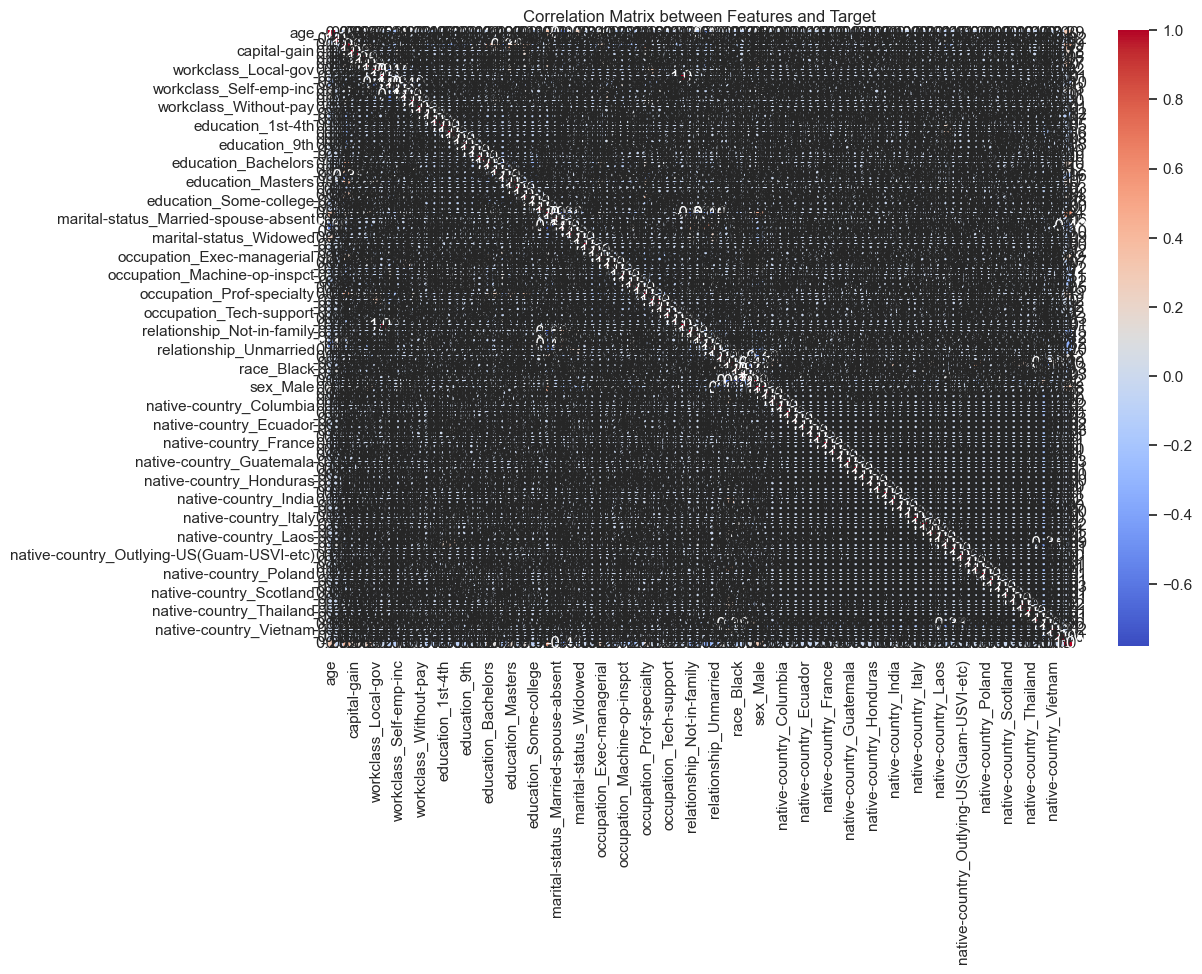

In [ ]:
#%%

# 14. Correlation matrix - 98 columns, unreadable plot
correlation_matrix_l = resampled_data_train.corr(method='pearson', min_periods=1, numeric_only=False)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_l, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix between Features and Target')
if not os.path.exists('./census_income/plots/bad_cm.png'):
    plt.savefig('./census_income/plots/bad_cm.png')
plt.show()

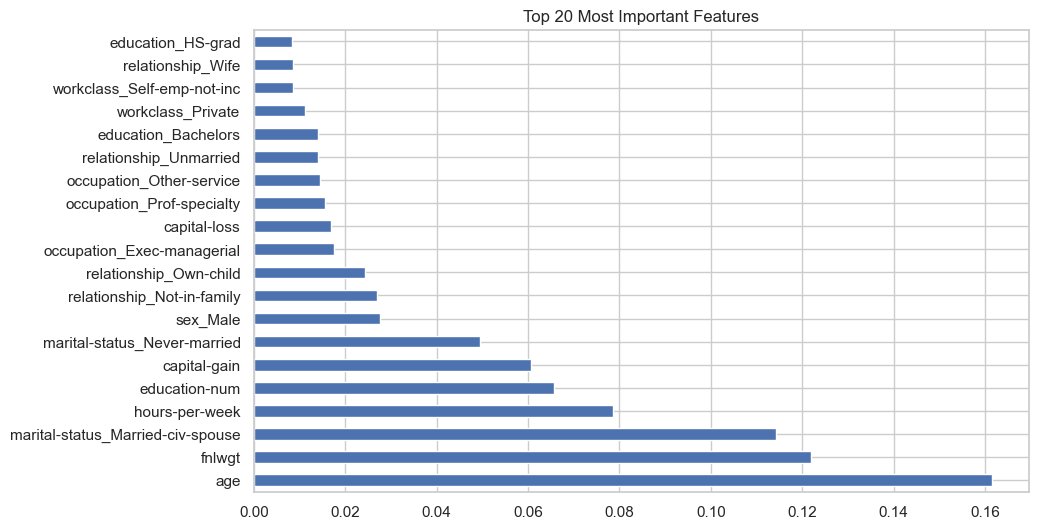

In [ ]:
#%%

# 15. Feature selection - Random Forest Classifier
feature_selector = RandomForestClassifier(random_state=37)
feature_selector.fit(X_resampled, y_resampled)
feature_importances = pd.Series(feature_selector.feature_importances_, index=X_train.columns)
top_features = feature_importances.nlargest(20)

if not os.path.exists('./census_income/models/top_features.pkl'):
    with open('./census_income/models/top_features.pkl', 'wb') as f:
        pickle.dump(top_features, f)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', title='Top 20 Most Important Features')
if not os.path.exists('./census_income/plots/top_features.png'):
    plt.savefig('./census_income/plots/top_features.png')
plt.show()

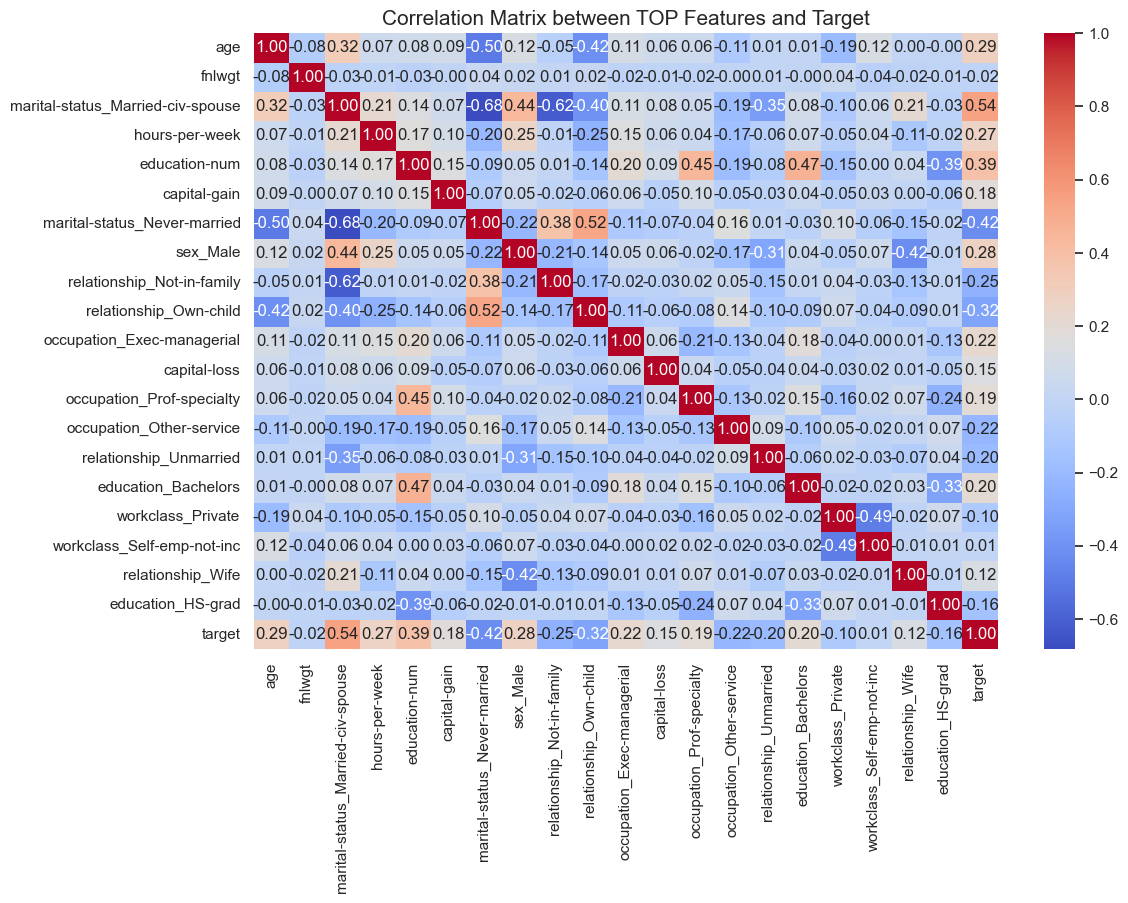

In [ ]:
#%% 

# 16. New correlation matrix - Top features. Good information
correlation_data = resampled_data_train[top_features.index.tolist() + ['target']]
correlation_matrix_w = correlation_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_w, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix between TOP Features and Target', fontsize=15)
if not os.path.exists('./census_income/plots/good_cm.png'):
    plt.savefig('./census_income/plots/good_cm.png')
plt.show()

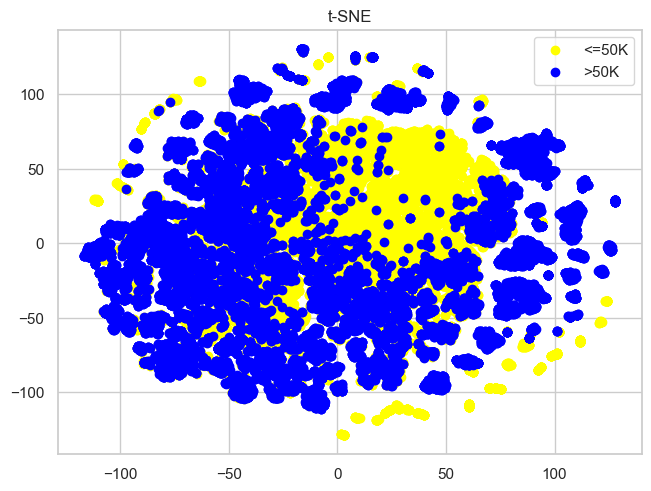

In [ ]:
#%%

# 17. Dimensionality Visualization
# t-SNE
data_embedded_TSNE = TSNE(n_components=2, random_state=37).fit_transform(X_resampled)

fig = plt.figure(facecolor="white", constrained_layout=True)
ax = fig.add_subplot()

ax.scatter(data_embedded_TSNE[(y_resampled == 0),0], data_embedded_TSNE[(y_resampled == 0),1], c='yellow',  label="<=50K")
ax.scatter(data_embedded_TSNE[(y_resampled == 1),0], data_embedded_TSNE[(y_resampled == 1),1], c='blue',    label=">50K")

ax.legend()

ax.set_title('t-SNE')
ax.grid(True)

if not os.path.exists('./census_income/plots/t-SNE.png'):
    plt.savefig('./census_income/plots/t-SNE.png')
plt.show() 

In [ ]:
#%%

# 18. Classifiers
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=37)),
    ('SVC (non-linear)', SVC(kernel='rbf', random_state=37)),
    ('Logistic Regression', LogisticRegression(max_iter=5000, random_state=37)),
    ('XGBoost', XGBClassifier(random_state=37))
]

# Trained with top features only
top_features_X_train = resampled_data_train[top_features.index.tolist()]

In [ ]:
#%%

acc_scores = []
for name, clf in (classifiers):
    print (f"Evaluating {name}!")
    # Cross-validation
    score = cross_val_score(clf, top_features_X_train, y_resampled,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')
    acc_scores.append((name, score.mean()))    

print(acc_scores)

Evaluating Random Forest!
Evaluating SVC (non-linear)!
Evaluating Logistic Regression!
Evaluating XGBoost!
[('Random Forest', 0.8638893357729629), ('SVC (non-linear)', 0.6259759447665585), ('Logistic Regression', 0.8242862331819648), ('XGBoost', 0.8727138161540371)]


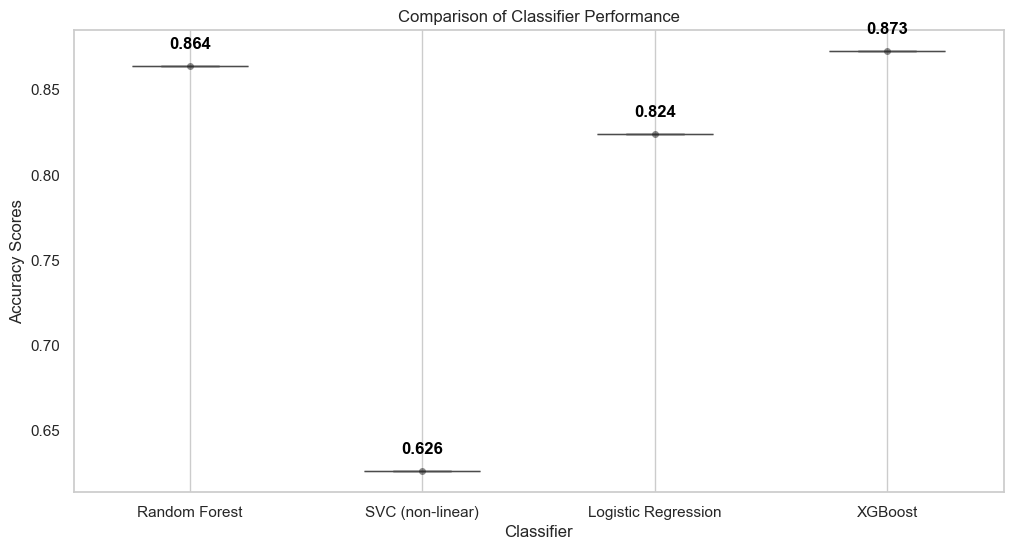

The best classifier is: XGBoost with an accuracy of 0.8727


In [ ]:
#%%

# 19. Boxplot algorithm comparison
results = pd.DataFrame(acc_scores, columns=['Classifier', 'Scores'])
results = results.explode('Scores')
plt.figure(figsize=(12, 6))
sns.boxplot(x='Classifier', y='Scores', data=results, boxprops=dict(alpha=0.5), width=0.5)
sns.swarmplot(x='Classifier', y='Scores', data=results, color='k', alpha=0.5)

mean_scores = results.groupby('Classifier')['Scores'].mean().reset_index()

for index, row in mean_scores.iterrows():
    plt.text(row['Classifier'], row['Scores'] + 0.01, f"{row['Scores']:.3f}", 
             horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.title('Comparison of Classifier Performance')
plt.xlabel('Classifier')
plt.ylabel('Accuracy Scores')
plt.grid()
if not os.path.exists('./census_income/plots/classifier_comparison.png'):
    plt.savefig('./census_income/plots/classifier_comparison.png')
plt.show()

# Find best classifier
best = ['', 0]
for name, score in acc_scores:
    if score > best[1]:
        best[0] = name
        best[1] = score

print(f"The best classifier is: {best[0]} with an accuracy of {best[1]:.4f}")

In [ ]:
#%%

# 20. Grid Search CV
resampled_data_test = pd.DataFrame(X_test, columns=X_test.columns) 
top_features_X_test = resampled_data_test[top_features.index.tolist()]
xgb_cpu = XGBClassifier(random_state=37)

In [ ]:
#%%

param_grid = {
    'n_estimators': [50, 80],         
    'max_depth': [15, 20],               
    'learning_rate': [0.1],
    'subsample': [0.8, 1],           
    'colsample_bytree': [0.8],         
    'gamma': [0, 0.3, 0.6],                                
}

grid_search = GridSearchCV(estimator=xgb_cpu,
                           param_grid=param_grid,
                           cv=3,               
                           scoring='accuracy', 
                           verbose=1,          
                           n_jobs=-1)          

start = time.time()
grid_search.fit(top_features_X_train, y_resampled,  eval_set=[(top_features_X_test, y_test)], verbose=False)
print("CPU GridSearchCV Time: %s seconds" % (str(time.time() - start)))

print(f"{grid_search.best_params_=}")
print(f"{grid_search.best_score_}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
CPU GridSearchCV Time: 33.50666809082031 seconds
grid_search.best_params_={'colsample_bytree': 0.8, 'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 80, 'subsample': 1}
0.864719133247943


In [ ]:
#%%

# 21. RandomizedSearchCV
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': np.arange(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': np.linspace(0, 0.5, 5),
    'reg_alpha': np.logspace(-3, 0, 5),
    'reg_lambda': np.logspace(-1, 1, 5)
}

random_search = RandomizedSearchCV(estimator=xgb_cpu, param_distributions=param_dist, 
                                   n_iter=50, scoring='accuracy', cv=5, verbose=1, random_state=42)

start = time.time()
random_search.fit(top_features_X_train, y_resampled,  eval_set=[(top_features_X_test, y_test)], verbose=False)
print("CPU RandomizedSearchCV Time: %s seconds" % (str(time.time() - start)))

print(f"{random_search.best_params_=}")
print(f"{random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
CPU RandomizedSearchCV Time: 129.10200142860413 seconds
random_search.best_params_={'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.10666666666666666, 'gamma': 0.25, 'colsample_bytree': 0.8}
0.8694521630261702


In [ ]:
#%%

# 22. Cross-validation - best model
best_params = random_search.best_params_ if random_search.best_score_ > grid_search.best_score_ else grid_search.best_params_

best_clf = XGBClassifier(**best_params)
best_score = cross_val_score(best_clf, top_features_X_train, y_resampled,
                             cv=StratifiedKFold(n_splits=5, random_state=37, shuffle=True), scoring='accuracy')
print(best_score)

[0.86925134 0.88487766 0.87966306 0.87204172 0.86736195]


In [ ]:
best_score.mean()

0.8746391428977965

In [ ]:
# %%

# 23. Train and save our best model
best_clf.fit(top_features_X_train, y_resampled,  eval_set=[(top_features_X_test, y_test)])
if not os.path.exists('./census_income/models/model_LR_undersampling.joblib'):
    dump(best_clf, './census_income/models/model_LR_undersampling.joblib')

[0]	validation_0-logloss:0.64069
[1]	validation_0-logloss:0.59942
[2]	validation_0-logloss:0.56254
[3]	validation_0-logloss:0.53245
[4]	validation_0-logloss:0.50627
[5]	validation_0-logloss:0.48595
[6]	validation_0-logloss:0.47035
[7]	validation_0-logloss:0.45624
[8]	validation_0-logloss:0.44152
[9]	validation_0-logloss:0.43143
[10]	validation_0-logloss:0.41973
[11]	validation_0-logloss:0.40992
[12]	validation_0-logloss:0.40226
[13]	validation_0-logloss:0.39612
[14]	validation_0-logloss:0.38894
[15]	validation_0-logloss:0.38208
[16]	validation_0-logloss:0.37694
[17]	validation_0-logloss:0.37206
[18]	validation_0-logloss:0.36781
[19]	validation_0-logloss:0.36399
[20]	validation_0-logloss:0.36131
[21]	validation_0-logloss:0.35772
[22]	validation_0-logloss:0.35507
[23]	validation_0-logloss:0.35245
[24]	validation_0-logloss:0.34993
[25]	validation_0-logloss:0.34794
[26]	validation_0-logloss:0.34611
[27]	validation_0-logloss:0.34417
[28]	validation_0-logloss:0.34303
[29]	validation_0-loglos

In [ ]:
#%%

# 24. Testing best model with test set
y_train_pred = best_clf.predict(top_features_X_train)
train_accuracy = accuracy_score(y_resampled, y_train_pred)

y_test_pred = best_clf.predict(top_features_X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9146432773558669
Test Accuracy: 0.8434844917596479


<ipython-input-53-e9ca3a6a4493>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=labels, y=accuracies, palette="cividis", edgecolor='black')


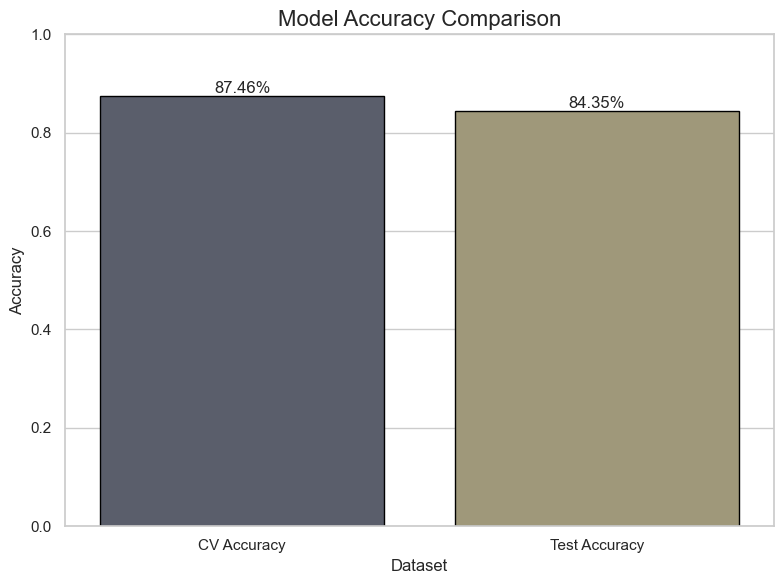

In [ ]:
# %%

# 25. Business Plots!
# Accuracy barplot
accuracies = [best_score.mean(), test_accuracy]
labels = ['CV Accuracy', 'Test Accuracy']

plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=labels, y=accuracies, palette="cividis", edgecolor='black')

plt.ylim(0, 1)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Dataset', fontsize=12)

for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=12)
    
plt.tight_layout()
if not os.path.exists('./census_income/plots/results_model_accuracy.png'):
    plt.savefig('./census_income/plots/results_model_accuracy.png')    
plt.show()

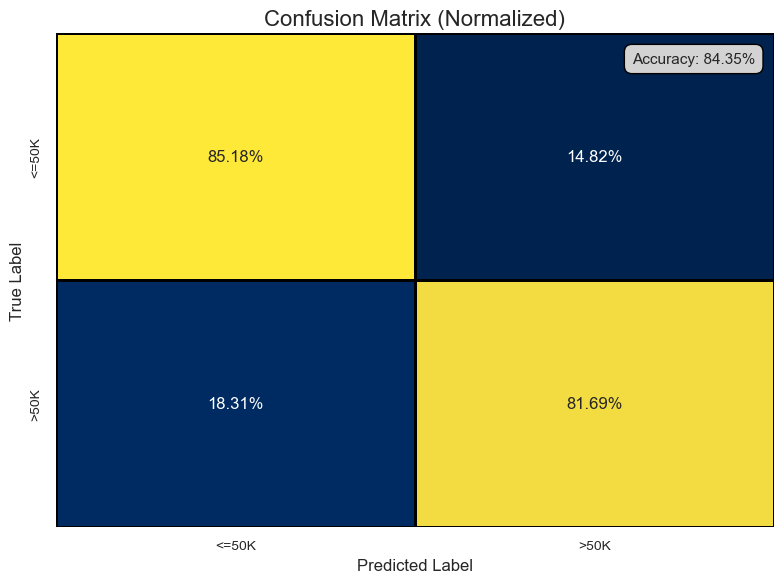

In [ ]:
#%%

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2%", cmap="cividis", cbar=False,
            xticklabels=["<=50K", ">50K"], yticklabels=["<=50K", ">50K"], linewidths=1, linecolor='black')

plt.title('Confusion Matrix (Normalized)', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

accuracy_text = f'Accuracy: {test_accuracy:.2%}'
plt.gcf().text(0.80, 0.88, accuracy_text, fontsize=11, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
if not os.path.exists('./census_income/plots/results_cm.png'):
    plt.savefig('./census_income/plots/results_cm.png')
plt.show()

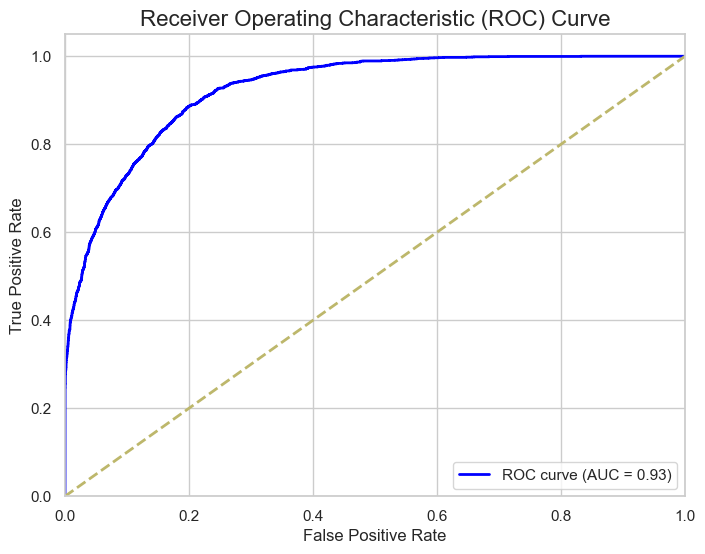

In [ ]:
# %%

# ROC - AUC
y_test_prob = best_clf.predict_proba(top_features_X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkkhaki', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
if not os.path.exists('./census_income/plots/results_roc.png'):
    plt.savefig('./census_income/plots/results_roc.png')
plt.show()